In this file I compute SHAP explanations and produce global maps of Pb concentration using the best model identified in 'Pb-conc_model-selection.ipynb'. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from xgboost import XGBRegressor
import shap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
import xarray as xr


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


##### Get same train-test split as in model-selection file

In [30]:
with open('../../Data/WOD_Pb_dataset-cleanedSOPbconc.csv', mode='r', newline='') as csvfile:
    WOD_pb_dataset = pd.read_csv(csvfile)
WOD_pb_dataset

Cruise  WOD_depth  WOD_latitude [degrees_north]  \
0              GA01         15                          40.5   
1              GA01         25                          40.5   
2              GA01         55                          40.5   
3              GA01        200                          40.5   
4              GA01        500                          40.5   
...             ...        ...                           ...   
9940  GP06-Chen2023        200                          29.5   
9941  GP06-Chen2023        300                          29.5   
9942  GP06-Chen2023        150                          29.5   
9943  GP06-Chen2023        500                          29.5   
9944  GP06-Chen2023         40                          29.5   

      WOD_longitude [degrees_east]  Pb_CONC [pmol/kg]  Pb_206_207  Pb_208_207  \
0                            -12.5          30.100000      1.1798      2.4483   
1                            -12.5          28.500000      1.1771      2.4479   
2                            -12.5          27.299999      1.1781      2.4495   
3                            -12.5          32.000000      1.1871      2.4515   
4                            -12.5          34.799999      1.1789      2.4514   
...                            ...                ...         ...         ...   
9940                         130.5          53.977687      1.1648      2.4493   
9941                         130.5          56.898171      1.1641      2.4493   
9942                         130.5          45.360875         NaN         NaN   
9943                         130.5          39.556952         NaN         NaN   
9944                         130.5          40.600803         NaN         NaN   

     Ocean_basin  Salinity  Temperature  ...  Nitrate  Phosphate   Oxygen  \
0       Atlantic    35.985       17.068  ...    0.990      0.125  246.679   
1       Atlantic    35.984       16.883  ...    1.087      0.130  247.044   
2       Atlantic    35.965       15.424  ...    1.952      0.165  246.471   
3       Atlantic    35.799       13.013  ...    7.936      0.456  230.087   
4       Atlantic    35.634       11.463  ...   13.444      0.781  207.979   
...          ...       ...          ...  ...      ...        ...      ...   
9940     Pacific    34.725       18.135  ...    4.981      0.411  191.026   
9941     Pacific    34.618       15.491  ...    8.925      0.719  178.790   
9942     Pacific    34.752       19.751  ...    2.939      0.287  197.577   
9943     Pacific    34.361       10.335  ...   20.145      1.467  145.696   
9944     Pacific    34.588       23.882  ...    0.377      0.105  211.573   

          AOU     MLD   Sigma  Chlorophyll-a  Black Carbon AOD  Dust AOD  \
0      -5.164  86.271  26.381       0.161568          0.005372  0.012002   
1      -4.812  86.271  26.476       0.161568          0.005372  0.012002   
2      -0.496  86.271  26.906       0.161568          0.005372  0.012002   
3      28.816  86.271  27.933       0.161568          0.005372  0.012002   
4      59.479  86.271  29.467       0.161568          0.005372  0.012002   
...       ...     ...     ...            ...               ...       ...   
9940   43.117  62.998  25.955       0.298270          0.011949  0.018216   
9941   67.295  62.998  26.933       0.298270          0.011949  0.018216   
9942   30.128  62.998  25.364       0.298270          0.011949  0.018216   
9943  126.283  62.998  28.667       0.298270          0.011949  0.018216   
9944    0.994  62.998  23.644       0.298270          0.011949  0.018216   

      Bottom_distance  
0              5243.0  
1              5233.0  
2              5203.0  
3              5058.0  
4              4758.0  
...               ...  
9940           2867.0  
9941           2767.0  
9942           2917.0  
9943           2567.0  
9944           3027.0  

[9945 rows x 21 columns]

In [5]:
pb_conc_dataset = WOD_pb_dataset.dropna(subset = ['Pb_CONC [pmol/kg]'])
len(pb_conc_dataset)

9920

In [ ]:
pb_conc_dataset_ref = pb_conc_dataset.copy()

In [4]:
basins = WOD_pb_dataset['Ocean_basin'].unique()

for basin in basins:
    mean = WOD_pb_dataset[WOD_pb_dataset['Ocean_basin'] == basin]['Pb_CONC [pmol/kg]'].mean()
    std = WOD_pb_dataset[WOD_pb_dataset['Ocean_basin'] == basin]['Pb_CONC [pmol/kg]'].std()
    print(f'{basin} mean: {mean}, std: {std}')


Atlantic mean: 20.791473985243325, std: 10.428011838258472
Southern mean: 12.938131971005554, std: 10.840823370420777
Pacific mean: 17.917708198661487, std: 14.53554386037465
Indian mean: 21.573533674377227, std: 16.45729116170755
Arctic mean: 6.091383023809524, std: 5.52760927979475


In [9]:
pb_conc_dataset.drop(['Ocean_basin'], axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
idx_1 = pb_conc_dataset[(pb_conc_dataset['Cruise'] == 'GA03') & (pb_conc_dataset['WOD_latitude [degrees_north]'] < 30) & (pb_conc_dataset['WOD_latitude [degrees_north]'] > 10) & (pb_conc_dataset['WOD_longitude [degrees_east]'] > -65) & (pb_conc_dataset['WOD_longitude [degrees_east]'] < -30)].index

test_geo_NA = pb_conc_dataset.loc[idx_1]
#test_geo_NA

In [11]:
dataset = pb_conc_dataset.drop(idx_1)
#dataset

In [12]:
y_test_geo_NA = test_geo_NA['Pb_CONC [pmol/kg]']
X_test_geo_NA = test_geo_NA.drop(['Pb_CONC [pmol/kg]', 'Pb_206_207', 'Pb_208_207', 'Cruise'], axis=1)

In [13]:
y = dataset['Pb_CONC [pmol/kg]']
X = dataset.drop(['Pb_CONC [pmol/kg]', 'Pb_206_207', 'Pb_208_207', 'Cruise'], axis=1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)
#print((len(X_test) + len(X_test_geo_NA))/len(pb_conc_dataset))

In [15]:
for data in [X, X_train, X_test, X_test_geo_NA]:
    data.drop(['WOD_latitude [degrees_north]', 'WOD_longitude [degrees_east]'], axis=1, inplace=True)

### <strong style = "color:cyan"> XGBoost - model analysis </strong>

In [17]:
model_grid = pd.read_csv('Model_output/XGBoost-cleanedSOPbconc-GridsearchCV_results_20241017-164328_with-test-performance.csv')
model_grid.sort_values(by='rank_test_score', inplace=True)
model_grid

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
348      46.747585      1.543531         0.648125        0.050893   
347      44.707022      1.589292         0.558011        0.039303   
349      48.073136      1.848996         0.646580        0.064999   
346      42.294869      1.582966         0.638621        0.080238   
345      40.591688      1.366056         0.531702        0.042528   
..             ...           ...              ...             ...   
275      21.122737      0.886204         0.431874        0.080153   
276      22.938098      0.723990         0.439183        0.041160   
277      25.808736      0.710741         0.463133        0.056139   
278      27.408965      0.894043         0.508843        0.059841   
279      29.355461      0.763766         0.599258        0.049591   

     param_colsample_bytree  param_learning_rate  param_max_depth  \
348                     0.7                 0.01               14   
347                     0.7                 0.01               14   
349                     0.7                 0.01               14   
346                     0.7                 0.01               14   
345                     0.7                 0.01               14   
..                      ...                  ...              ...   
275                     0.5                 0.30               14   
276                     0.5                 0.30               14   
277                     0.5                 0.30               14   
278                     0.5                 0.30               14   
279                     0.5                 0.30               14   

     param_min_child_weight  param_n_estimators  \
348                       8                1500   
347                       8                1400   
349                       8                1600   
346                       8                1300   
345                       8                1200   
..                      ...                 ...   
275                      12                1200   
276                      12                1300   
277                      12                1400   
278                      12                1500   
279                      12                1600   

                                                params  ...  \
348  {'colsample_bytree': 0.7, 'learning_rate': 0.0...  ...   
347  {'colsample_bytree': 0.7, 'learning_rate': 0.0...  ...   
349  {'colsample_bytree': 0.7, 'learning_rate': 0.0...  ...   
346  {'colsample_bytree': 0.7, 'learning_rate': 0.0...  ...   
345  {'colsample_bytree': 0.7, 'learning_rate': 0.0...  ...   
..                                                 ...  ...   
275  {'colsample_bytree': 0.5, 'learning_rate': 0.3...  ...   
276  {'colsample_bytree': 0.5, 'learning_rate': 0.3...  ...   
277  {'colsample_bytree': 0.5, 'learning_rate': 0.3...  ...   
278  {'colsample_bytree': 0.5, 'learning_rate': 0.3...  ...   
279  {'colsample_bytree': 0.5, 'learning_rate': 0.3...  ...   

     split2_test_score  split3_test_score  split4_test_score  mean_test_score  \
348          -0.222331          -0.227555          -0.207241        -0.210967   
347          -0.222585          -0.227480          -0.207302        -0.210993   
349          -0.222450          -0.227493          -0.207197        -0.211039   
346          -0.222934          -0.227662          -0.207516        -0.211133   
345          -0.223180          -0.227873          -0.207704        -0.211264   
..                 ...                ...                ...              ...   
275          -0.269658          -0.271787          -0.251281        -0.257936   
276          -0.269717          -0.271909          -0.251304        -0.258009   
277          -0.269758          -0.271966          -0.251333        -0.258065   
278          -0.269796          -0.272039          -0.251373        -0.258113   
279          -0.269830          -0.272076          -0.251387        -0.258142   

    

In [18]:
best_xgb_model = XGBRegressor(colsample_bytree=model_grid['param_colsample_bytree'].to_numpy()[0], 
                              learning_rate=model_grid['param_learning_rate'].to_numpy()[0], 
                              max_depth=model_grid['param_max_depth'].to_numpy()[0], 
                              min_child_weight=model_grid['param_min_child_weight'].to_numpy()[0], 
                              n_estimators=model_grid['param_n_estimators'].to_numpy()[0], 
                              early_stopping_rounds=50,
                              eval_metric = 'mape',
                              seed=42)

best_xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)

[0]	validation_0-mape:1.53317	validation_1-mape:1.59387
[1]	validation_0-mape:1.51943	validation_1-mape:1.57996
[2]	validation_0-mape:1.50584	validation_1-mape:1.56611
[3]	validation_0-mape:1.49276	validation_1-mape:1.55279
[4]	validation_0-mape:1.47959	validation_1-mape:1.53951
[5]	validation_0-mape:1.46631	validation_1-mape:1.52584
[6]	validation_0-mape:1.45324	validation_1-mape:1.51252
[7]	validation_0-mape:1.44047	validation_1-mape:1.49984
[8]	validation_0-mape:1.42757	validation_1-mape:1.48655
[9]	validation_0-mape:1.41498	validation_1-mape:1.47382
[10]	validation_0-mape:1.40259	validation_1-mape:1.46129
[11]	validation_0-mape:1.39007	validation_1-mape:1.44841
[12]	validation_0-mape:1.37777	validation_1-mape:1.43589
[13]	validation_0-mape:1.36567	validation_1-mape:1.42364
[14]	validation_0-mape:1.35370	validation_1-mape:1.41152
[15]	validation_0-mape:1.34182	validation_1-mape:1.39945
[16]	validation_0-mape:1.32995	validation_1-mape:1.38744
[17]	validation_0-mape:1.31878	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='mape', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [19]:
y_pred = best_xgb_model.predict(X_test, iteration_range=(0, best_xgb_model.best_iteration + 1))
y_pred_geo_NA = best_xgb_model.predict(X_test_geo_NA, iteration_range=(0, best_xgb_model.best_iteration + 1))

In [20]:
test_set_with_pred = X_test.copy()
test_set_with_pred['y_test'] = y_test
test_set_with_pred['y_pred'] = y_pred

In [21]:
merged_df = pd.merge(test_set_with_pred, pb_conc_dataset_ref, left_index=True, right_index=True)

In [22]:
merged_test_set = pd.merge(test_set_with_pred, pb_conc_dataset_ref, left_index=True, right_index=True)
merged_test_set

WOD_depth_x  Salinity_x  Temperature_x  Silicate_x  Nitrate_x  \
511           200      33.734          3.898      66.626     31.070   
7717         4400      34.783          1.347      74.674     26.505   
9011          100      33.335         -1.079      12.945      9.740   
1759          650      34.405          5.684      86.759     40.440   
6414          150      35.381         15.149       2.689      5.179   
...           ...         ...            ...         ...        ...   
4508         2500      34.645          1.645     167.650     39.628   
6021         1000      34.298          3.251      39.883     32.351   
412          1000      35.100          6.770      13.739     20.553   
6178            5      35.341         16.689       1.673      0.640   
2323          375      34.735         10.103      35.953     34.224   

      Phosphate_x  Oxygen_x    AOU_x    MLD_x  Sigma_x  ...  Nitrate_y  \
511         2.297   152.759  173.040   69.683   27.737  ...     31.070   
7717        1.756   238.808  103.087   55.209   48.009  ...     26.505   
9011        1.078   323.774   54.365   29.598   27.333  ...      9.740   
1759        3.014    36.034  273.655   62.623   30.128  ...     40.440   
6414        0.458   220.337   28.045   66.265   26.918  ...      5.179   
...           ...       ...      ...      ...      ...  ...        ...   
4508        2.853   100.906  239.974   50.897   39.392  ...     39.628   
6021        2.052   222.508  100.959   99.170   31.997  ...     32.351   
412         1.309   196.424  100.012  127.848   32.092  ...     20.553   
6178        0.249   245.267   -3.361  114.888   25.900  ...      0.640   
2323        2.769     9.874  266.061   32.059   28.443  ...     34.224   

      Phosphate_y  Oxygen_y    AOU_y    MLD_y  Sigma_y Chlorophyll-a_y  \
511         2.297   152.759  173.040   69.683   27.737        0.305943   
7717        1.756   238.808  103.087   55.209   48.009        0.084474   
9011        1.078   323.774   54.365   29.598   27.333        0.319013   
1759        3.014    36.034  273.655   62.623   30.128        0.082903   
6414        0.458   220.337   28.045   66.265   26.918        0.147873   
...           ...       ...      ...      ...      ...             ...   
4508        2.853   100.906  239.974   50.897   39.392        0.353186   
6021        2.052   222.508  100.959   99.170   31.997        0.324626   
412         1.309   196.424  100.012  127.848   32.092        0.369677   
6178        0.249   245.267   -3.361  114.888   25.900        0.312581   
2323        2.769     9.874  266.061   32.059   28.443        0.567867   

      Black Carbon AOD_y  Dust AOD_y  Bottom_distance_y  
511             0.007685    0.003604               5584  
7717            0.009312    0.025950                 12  
9011            0.004955    0.000449               1172  
1759            0.003931    0.001686                680  
6414            0.002993    0.001308               4711  
...                  ...         ...                ...  
4508            0.006756    0.001843               3974  
6021            0.003033    0.000653               3450  
412             0.005176    0.006491               4441  
6178            0.002826    0.001368               3506  
2323            0.010809    0.001750               5158  

[1941 rows x 37 columns]

### SHAP

In [ ]:
explainer = shap.TreeExplainer(best_xgb_model, X_train, feature_perturbation="interventional")

all_X = pd.concat([X_train, X_test, X_test_geo_NA])
shap_values = explainer(all_X)

In [ ]:
shap_col_names = []

for i in range(len(all_X.columns)):
    shap_col_names.append('SHAP_' + all_X.columns[i])

shap_values_df = pd.DataFrame(shap_values.values, columns=shap_col_names)

In [ ]:
shap_values_df_all = pd.concat([all_X.reset_index(drop=True), shap_values_df.reset_index(drop=True)], axis=1)
shap_values_df_all.to_csv('Model_output/XGBoost-cleanedSOPbconc-SHAP_values.csv', index=False)

#with open('Model_output/XGBoost-cleanedSOPbconc-SHAP_values.csv', mode='r', newline='') as csvfile:
#    shap_values_df_all = pd.read_csv(csvfile)

shap_values_df_all

WOD_depth  Salinity  Temperature  Silicate  Nitrate  Phosphate   Oxygen  \
0           700    34.899        3.861     9.297   16.301      1.082  287.962   
1            60    33.363       10.387     7.267    3.432      0.569  277.019   
2           550    35.088        8.273    10.929   17.705      1.153  207.150   
3           200    34.479        1.419     7.152   10.884      0.756  304.327   
4          4600    34.694        0.649   131.352   32.573      2.336  211.289   
...         ...       ...          ...       ...      ...        ...      ...   
9915       5100    34.857        2.096    50.514   22.139      1.521  251.278   
9916       3300    34.922        2.660    36.211   20.447      1.381  249.574   
9917       3400    34.921        2.645    36.680   20.398      1.387  249.443   
9918       3300    34.922        2.660    36.211   20.447      1.381  249.574   
9919       3300    34.922        2.660    36.211   20.447      1.381  249.574   

          AOU      MLD   Sigma  ...  SHAP_Nitrate  SHAP_Phosphate  \
0      29.023  593.250  31.011  ...      0.663035        0.583873   
1      -3.072   61.956  25.894  ...      0.198421        0.066627   
2      82.317  133.769  29.859  ...      0.579807        0.327854   
3      32.165   45.664  28.816  ...      0.047029       -0.233500   
4     134.330   48.119  48.973  ...     -0.271481       -0.328847   
...       ...      ...     ...  ...           ...             ...   
9915   84.458   57.941  51.012  ...     -0.004415       -0.349617   
9916   78.964   68.652  43.019  ...      0.122125       -0.066119   
9917   79.100   68.652  43.468  ...      0.196308       -0.153947   
9918   78.964   68.652  43.019  ...      0.122125       -0.066119   
9919   78.964   68.652  43.019  ...      0.122125       -0.066119   

      SHAP_Oxygen  SHAP_AOU  SHAP_MLD  SHAP_Sigma  SHAP_Chlorophyll-a  \
0       -0.022413  0.246254  1.750206    0.824805           -0.191027   
1       -0.146328 -0.831398  0.105102    0.633879           -0.895353   
2       -0.025213  0.159038  0.578867    0.259632           -0.174628   
3       -0.408549  0.043135  0.424819    0.387254           -0.431332   
4       -0.016278 -0.128272  0.314373   -1.025346            0.219400   
...           ...       ...       ...         ...                 ...   
9915     0.092476  0.034667  0.032266   -1.446681           -0.125871   
9916     0.127667 -0.017131 -0.194245   -1.268265            0.422690   
9917     0.133772  0.020708 -0.159557   -1.266991            0.457323   
9918     0.127667 -0.017131 -0.194245   -1.268265            0.422690   
9919     0.127667 -0.017131 -0.194245   -1.268265            0.422690   

      SHAP_Black Carbon AOD  SHAP_Dust AOD  SHAP_Bottom_distance  
0                  1.218617      -1.597498              0.299603  
1                  1.699178       6.404139              0.670452  
2                  3.452391       1.561215              0.085861  
3                 -0.506440      -2.743251              0.182419  
4                  1.227886      -0.586219             -0.528347  
...                     ...            ...                   ...  
9915               1.266072       3.733535             -0.696822  
9916               1.426276       4.838464             -0.611315  
9917               1.387413       4.803310             -0.883107  
9918               1.426276       4.838464             -0.611315  
9919               1.426276       4.838464             -0.611315  

[9920 rows x 28 columns]

In [255]:
name_map = {
    "Dust AOD": "Dust AOD",
    "Temperature": "Temperature [°C]",
    "Black Carbon AOD": "Black Carbon AOD",
    "Salinity": "Salinity",
    "Oxygen": "Oxygen [µmol/kg]", 
    "Sigma": "Density [kg/m³]",
    "Silicate": "Silicate [µmol/kg]",
    "MLD": "Mixed layer depth [m]",
    "Bottom_distance": "Bottom distance [m]",
    "Chlorophyll-a": "Chlorophyll-a [mg/m³]",
    "Phosphate": "Phosphate [µmol/kg]",
    "Nitrate": "Nitrate [µmol/kg]",
    "WOD_depth": "Depth [m]",
    "AOU": "Apparent oxygen utilization [µmol/kg]"
}
mapped_feature_names = list(map(lambda x: name_map.get(x, x), X.columns))
shap_values.feature_names = mapped_feature_names

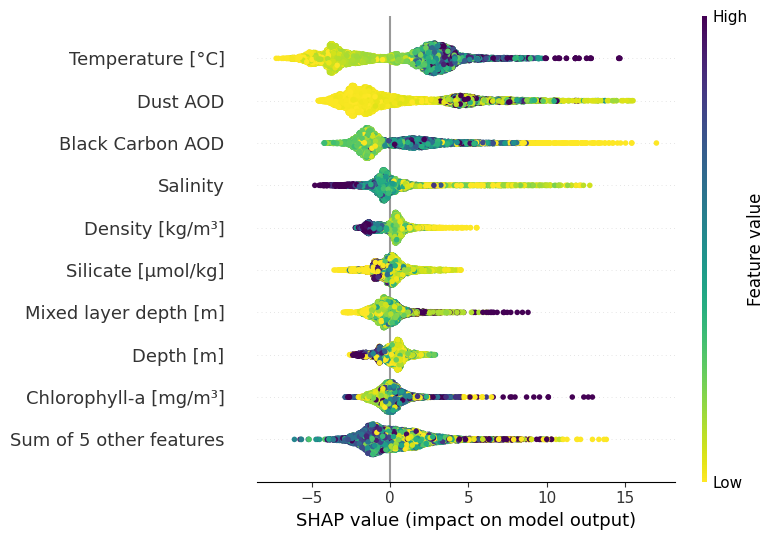

In [256]:
plt.figure()
shap.plots.beeswarm(shap_values, color = 'viridis_r', show=False)
plt.tight_layout()

plt.savefig('../../Figures/For_ms/Pb-conc-cleanedSOno-coords_shap_beeswarm.png', dpi = 400)

In [257]:
feature_names = shap_values.feature_names
shap_df = pd.DataFrame(shap_values.values, columns=feature_names)
vals = np.abs(shap_df.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['col_name', 'feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
main_features = shap_importance[0:9].col_name.values
shap_importance.set_index(np.arange(1, len(shap_importance)+1), inplace=True)

shap_importance.to_csv('../../Tables/For_ms/Pb-conc-cleanedSO_no-coords_shap_importance.csv', index=False)
shap_importance


col_name  feature_importance_vals
1                        Temperature [°C]                 3.185870
2                                Dust AOD                 2.837951
3                        Black Carbon AOD                 2.010797
4                                Salinity                 0.992181
5                         Density [kg/m³]                 0.755530
6                      Silicate [µmol/kg]                 0.743976
7                   Mixed layer depth [m]                 0.707079
8                               Depth [m]                 0.677682
9                   Chlorophyll-a [mg/m³]                 0.626445
10                    Phosphate [µmol/kg]                 0.562715
11                    Bottom distance [m]                 0.489681
12                       Oxygen [µmol/kg]                 0.458826
13                      Nitrate [µmol/kg]                 0.411325
14  Apparent oxygen utilization [µmol/kg]                 0.224640

In [258]:
reverse_name_map = {v: k for k, v in name_map.items()}
reverse_name_map

{'Dust AOD': 'Dust AOD',
 'Temperature [°C]': 'Temperature',
 'Black Carbon AOD': 'Black Carbon AOD',
 'Salinity': 'Salinity',
 'Oxygen [µmol/kg]': 'Oxygen',
 'Density [kg/m³]': 'Sigma',
 'Silicate [µmol/kg]': 'Silicate',
 'Mixed layer depth [m]': 'MLD',
 'Bottom distance [m]': 'Bottom_distance',
 'Chlorophyll-a [mg/m³]': 'Chlorophyll-a',
 'Phosphate [µmol/kg]': 'Phosphate',
 'Nitrate [µmol/kg]': 'Nitrate',
 'Depth [m]': 'WOD_depth',
 'Apparent oxygen utilization [µmol/kg]': 'AOU'}

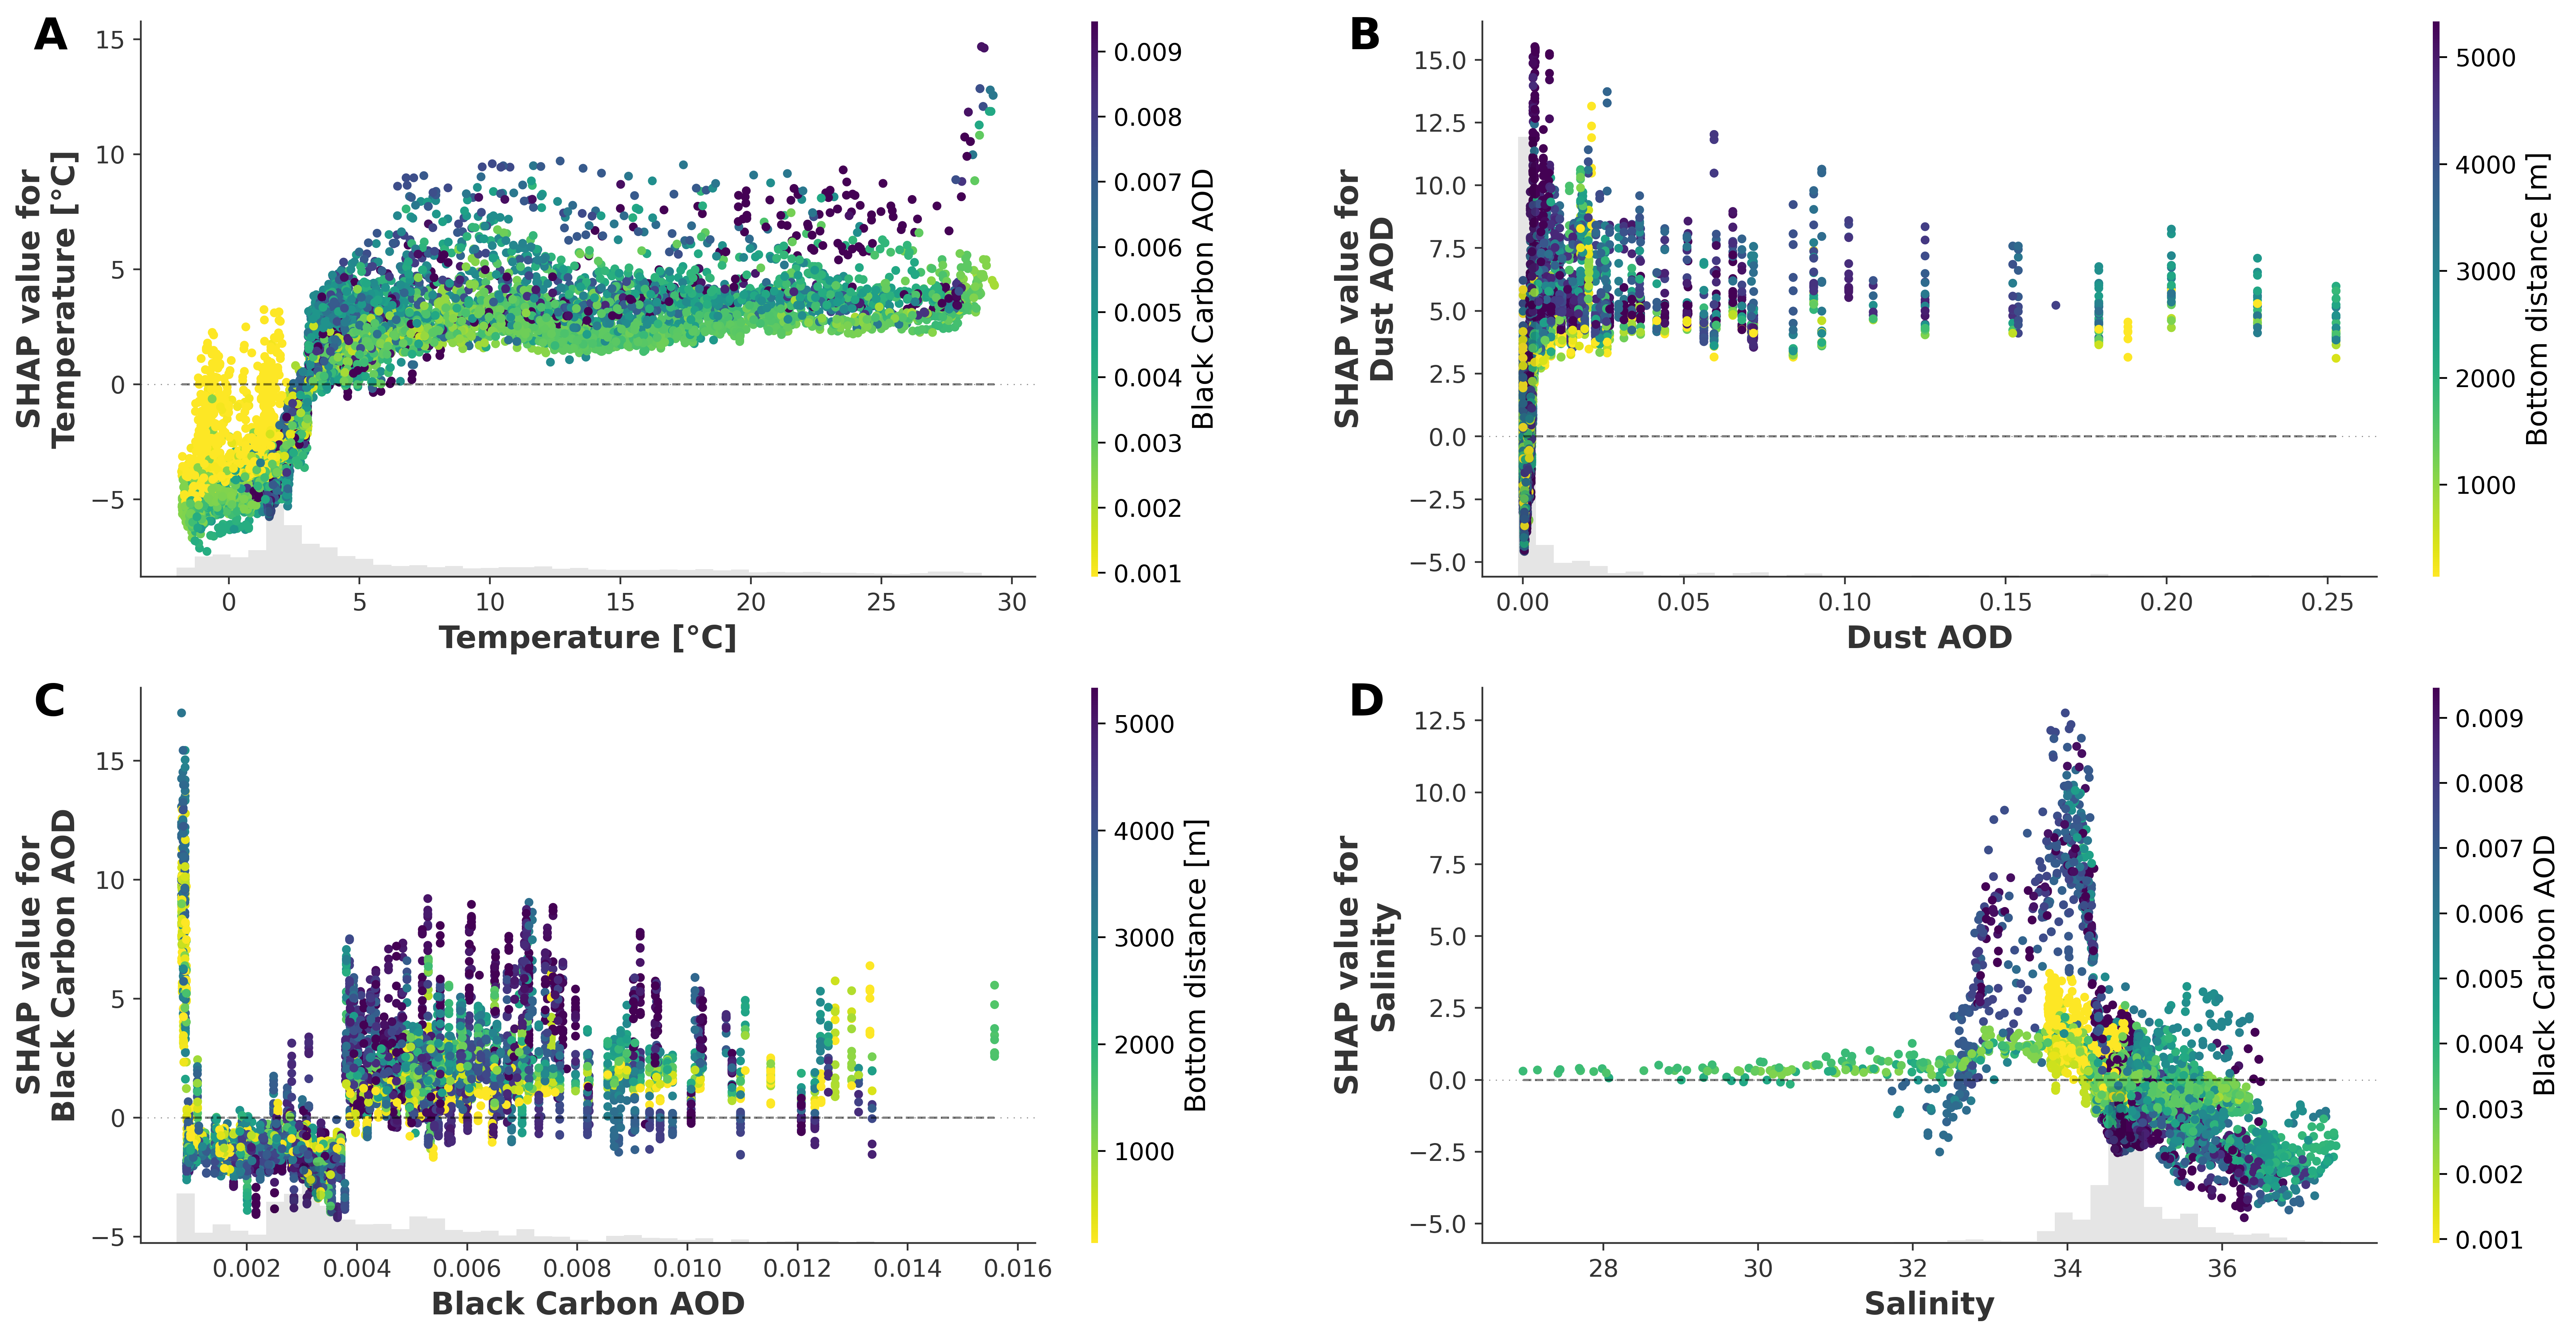

In [269]:
nrows = 2
ncols = 2
fig_label = ['A', 'B', 'C', 'D']

fig, ax = plt.subplots(nrows,ncols, figsize=(20, 10), dpi=400)
for i, ax_flt in zip(range(len(main_features)), ax.flat):
    shap.plots.scatter(shap_values[:,main_features[i]], ax=ax_flt, show=False, color=shap_values, cmap = 'viridis_r')
    ax_flt.hlines(0, xmin = all_X[reverse_name_map[main_features[i]]].min(), xmax = all_X[reverse_name_map[main_features[i]]].max(), linestyles='dashed', linewidth=1, color='black', alpha=0.5)
    ax_flt.set_xlabel(main_features[i], fontweight='bold', fontsize=14)
    ax_flt.set_ylabel(f'SHAP value for\n{main_features[i]}', fontweight='bold', fontsize=14)
    if i in [0,2]:
        ax_flt.text(-0.12, 0.95, f'{fig_label[i]}', transform=ax_flt.transAxes, fontsize=20, fontweight='bold')
    else:
        ax_flt.text(-0.15, 0.95, f'{fig_label[i]}', transform=ax_flt.transAxes, fontsize=20, fontweight='bold')
    #if i in [0, ncols]:
    #    ax_flt.set_ylabel('SHAP value', fontweight='bold')
    #else:
    #    ax_flt.set_ylabel('')

plt.savefig('../../Figures/For_ms/Pb-conc-cleanedSOno-coords_shap_scatter-dependence_4panels.png', dpi = 400)        


# <strong style = "color:Yellow"> Map global distribution </strong>

In [23]:
with open('../../Data/Global-prediction_masked-df_no-coords.csv', mode='r', newline='') as csvfile:
    prediction_df_latlon = pd.read_csv(csvfile)
prediction_df_latlon

WOD_latitude [degrees_north]  WOD_longitude [degrees_east]  Depth  \
0                               -76.5                        -179.5      0   
1                               -76.5                        -179.5      5   
2                               -76.5                        -179.5     10   
3                               -76.5                        -179.5     15   
4                               -76.5                        -179.5     20   
...                               ...                           ...    ...   
3300568                          89.5                         179.5   3700   
3300569                          89.5                         179.5   3800   
3300570                          89.5                         179.5   3900   
3300571                          89.5                         179.5   4000   
3300572                          89.5                         179.5   4100   

         Salinity  Temperature  Silicate  Nitrate  Phosphate   Oxygen     AOU  \
0          34.336       -1.489    66.786   23.699      1.731  329.686  32.191   
1          34.338       -1.504    65.701   23.764      1.726  328.966  32.839   
2          34.340       -1.518    66.094   23.987      1.735  327.762  33.466   
3          34.349       -1.461    66.145   24.062      1.746  326.322  34.773   
4          34.349       -1.469    66.372   24.318      1.761  325.139  36.318   
...           ...          ...       ...      ...        ...      ...     ...   
3300568    34.953       -0.527    11.339   14.569      1.004  297.053  59.287   
3300569    34.952       -0.518    11.356   14.554      1.004  296.844  59.387   
3300570    34.954       -0.546    11.325   14.518      1.006  297.770  58.866   
3300571    34.942       -0.670    11.228   14.473      1.008  299.008  58.407   
3300572    34.944       -0.658    11.021   14.465      1.007  299.160  58.156   

             MLD   Sigma  Chlorophyll-a  Black Carbon AOD  Dust AOD  \
0        290.354  27.701          0.465             0.001       0.0   
1        290.354  27.724          0.465             0.001       0.0   
2        290.354  27.721          0.465             0.001       0.0   
3        290.354  27.754          0.465             0.001       0.0   
4        290.354  27.782          0.465             0.001       0.0   
...          ...     ...            ...               ...       ...   
3300568   36.069  45.408          0.090             0.003       0.0   
3300569   36.069  45.860          0.090             0.003       0.0   
3300570   36.069  46.321          0.090             0.003       0.0   
3300571   36.069  46.788          0.090             0.003       0.0   
3300572   36.069  47.237          0.090             0.003       0.0   

         Bottom_distance  Ocean_basin  
0                  605.0         10.0  
1                  600.0         10.0  
2                  595.0         10.0  
3                  590.0         10.0  
4                  585.0         10.0  
...                  ...          ...  
3300568            450.0         11.0  
3300569            350.0         11.0  
3300570            250.0         11.0  
3300571            150.0         11.0  
3300572             50.0         11.0  

[3300573 rows x 17 columns]

In [24]:
prediction_df = prediction_df_latlon.drop(['WOD_latitude [degrees_north]', 'WOD_longitude [degrees_east]', 'Ocean_basin'], axis=1)
prediction_df.rename(columns={'Depth': 'WOD_depth'}, inplace=True)

In [25]:
global_preds = best_xgb_model.predict(prediction_df)
global_preds

array([14.40535  , 14.083039 , 11.607494 , ...,  7.8267455,  7.419924 ,
        7.7625484], dtype=float32)

In [26]:
global_preds.max()

77.64807

In [27]:
prediction_df['Pb_conc'] = global_preds
prediction_df_latlon['Pb_conc'] = global_preds

In [28]:
prediction_df_latlon = prediction_df_latlon.replace({'Ocean_basin': {1.0: 'Atlantic', 2.0: 'Pacific', 3.0: 'Indian', 10.0: 'Southern', 11.0: 'Arctic'}})
prediction_df_latlon

WOD_latitude [degrees_north]  WOD_longitude [degrees_east]  Depth  \
0                               -76.5                        -179.5      0   
1                               -76.5                        -179.5      5   
2                               -76.5                        -179.5     10   
3                               -76.5                        -179.5     15   
4                               -76.5                        -179.5     20   
...                               ...                           ...    ...   
3300568                          89.5                         179.5   3700   
3300569                          89.5                         179.5   3800   
3300570                          89.5                         179.5   3900   
3300571                          89.5                         179.5   4000   
3300572                          89.5                         179.5   4100   

         Salinity  Temperature  Silicate  Nitrate  Phosphate   Oxygen     AOU  \
0          34.336       -1.489    66.786   23.699      1.731  329.686  32.191   
1          34.338       -1.504    65.701   23.764      1.726  328.966  32.839   
2          34.340       -1.518    66.094   23.987      1.735  327.762  33.466   
3          34.349       -1.461    66.145   24.062      1.746  326.322  34.773   
4          34.349       -1.469    66.372   24.318      1.761  325.139  36.318   
...           ...          ...       ...      ...        ...      ...     ...   
3300568    34.953       -0.527    11.339   14.569      1.004  297.053  59.287   
3300569    34.952       -0.518    11.356   14.554      1.004  296.844  59.387   
3300570    34.954       -0.546    11.325   14.518      1.006  297.770  58.866   
3300571    34.942       -0.670    11.228   14.473      1.008  299.008  58.407   
3300572    34.944       -0.658    11.021   14.465      1.007  299.160  58.156   

             MLD   Sigma  Chlorophyll-a  Black Carbon AOD  Dust AOD  \
0        290.354  27.701          0.465             0.001       0.0   
1        290.354  27.724          0.465             0.001       0.0   
2        290.354  27.721          0.465             0.001       0.0   
3        290.354  27.754          0.465             0.001       0.0   
4        290.354  27.782          0.465             0.001       0.0   
...          ...     ...            ...               ...       ...   
3300568   36.069  45.408          0.090             0.003       0.0   
3300569   36.069  45.860          0.090             0.003       0.0   
3300570   36.069  46.321          0.090             0.003       0.0   
3300571   36.069  46.788          0.090             0.003       0.0   
3300572   36.069  47.237          0.090             0.003       0.0   

         Bottom_distance Ocean_basin    Pb_conc  
0                  605.0    Southern  14.405350  
1                  600.0    Southern  14.083039  
2                  595.0    Southern  11.607494  
3                  590.0    Southern  11.701458  
4                  585.0    Southern  11.504750  
...                  ...         ...        ...  
3300568            450.0      Arctic   7.782954  
3300569            350.0      Arctic   7.921970  
3300570            250.0      Arctic   7.826746  
3300571            150.0      Arctic   7.419924  
3300572             50.0      Arctic   7.762548  

[3300573 rows x 18 columns]

In [29]:
prediction_df_latlon.to_csv('../../Data/Pb_conc-predictions-no_coords.csv', index=False)

In [219]:
import gsw 

prediction_df_latlon['pressure'] = gsw.p_from_z(-prediction_df_latlon['Depth'], prediction_df_latlon['WOD_latitude [degrees_north]'])
prediction_df_latlon['conservative_temperature'] = gsw.CT_from_t(prediction_df_latlon['Salinity'], prediction_df_latlon['Temperature'], prediction_df_latlon['pressure'])
prediction_df_latlon['potential_density'] = gsw.sigma0(prediction_df_latlon['Salinity'], prediction_df_latlon['conservative_temperature'])
prediction_df_latlon

WOD_latitude [degrees_north]  WOD_longitude [degrees_east]  Depth  \
0                               -76.5                        -179.5      0   
1                               -76.5                        -179.5      5   
2                               -76.5                        -179.5     10   
3                               -76.5                        -179.5     15   
4                               -76.5                        -179.5     20   
...                               ...                           ...    ...   
3300568                          89.5                         179.5   3700   
3300569                          89.5                         179.5   3800   
3300570                          89.5                         179.5   3900   
3300571                          89.5                         179.5   4000   
3300572                          89.5                         179.5   4100   

         Salinity  Temperature  Silicate  Nitrate  Phosphate   Oxygen     AOU  \
0          34.336       -1.489    66.786   23.699      1.731  329.686  32.191   
1          34.338       -1.504    65.701   23.764      1.726  328.966  32.839   
2          34.340       -1.518    66.094   23.987      1.735  327.762  33.466   
3          34.349       -1.461    66.145   24.062      1.746  326.322  34.773   
4          34.349       -1.469    66.372   24.318      1.761  325.139  36.318   
...           ...          ...       ...      ...        ...      ...     ...   
3300568    34.953       -0.527    11.339   14.569      1.004  297.053  59.287   
3300569    34.952       -0.518    11.356   14.554      1.004  296.844  59.387   
3300570    34.954       -0.546    11.325   14.518      1.006  297.770  58.866   
3300571    34.942       -0.670    11.228   14.473      1.008  299.008  58.407   
3300572    34.944       -0.658    11.021   14.465      1.007  299.160  58.156   

         ...   Sigma  Chlorophyll-a  Black Carbon AOD  Dust AOD  \
0        ...  27.701          0.465             0.001       0.0   
1        ...  27.724          0.465             0.001       0.0   
2        ...  27.721          0.465             0.001       0.0   
3        ...  27.754          0.465             0.001       0.0   
4        ...  27.782          0.465             0.001       0.0   
...      ...     ...            ...               ...       ...   
3300568  ...  45.408          0.090             0.003       0.0   
3300569  ...  45.860          0.090             0.003       0.0   
3300570  ...  46.321          0.090             0.003       0.0   
3300571  ...  46.788          0.090             0.003       0.0   
3300572  ...  47.237          0.090             0.003       0.0   

         Bottom_distance  Ocean_basin    Pb_conc     pressure  \
0                  605.0     Southern  14.405350    -0.000000   
1                  600.0     Southern  14.083039     5.052873   
2                  595.0     Southern  11.607494    10.105870   
3                  590.0     Southern  11.701458    15.158991   
4                  585.0     Southern  11.504750    20.212236   
...                  ...          ...        ...          ...   
3300568            450.0       Arctic   7.782954  3773.425080   
3300569            350.0       Arctic   7.921970  3876.312831   
3300570            250.0       Arctic   7.826746  3979.247030   
3300571            150.0       Arctic   7.419924  4082.227592   
3300572             50.0       Arctic   7.762548  4185.254434   

         conservative_temperature  potential_density  
0                       -1.485296          27.503539  
1                       -1.500400          27.505626  
2                       -1.514504          27.507679  
3                       -1.457637          27.513160  
4                       -1.465740          27.513417  
...                           ...                ...  
3300568                 -0.764481          27.974008  
3300569                 -0.765461          27.973245  
3300570           

In [220]:
prediction_df_latlon_idxs = prediction_df_latlon.set_index(['WOD_latitude [degrees_north]', 'WOD_longitude [degrees_east]', 'Depth'])
prediction_df_latlon_idxs
prediction_xr = xr.Dataset.from_dataframe(prediction_df_latlon_idxs)
prediction_xr

<xarray.Dataset>
Dimensions:                       (WOD_latitude [degrees_north]: 167,
                                   WOD_longitude [degrees_east]: 360, Depth: 102)
Coordinates:
  * WOD_latitude [degrees_north]  (WOD_latitude [degrees_north]) float64 -76....
  * WOD_longitude [degrees_east]  (WOD_longitude [degrees_east]) float64 -179...
  * Depth                         (Depth) int64 0 5 10 15 ... 5300 5400 5500
Data variables: (12/18)
    Salinity                      (WOD_latitude [degrees_north], WOD_longitude [degrees_east], Depth) float64 ...
    Temperature                   (WOD_latitude [degrees_north], WOD_longitude [degrees_east], Depth) float64 ...
    Silicate                      (WOD_latitude [degrees_north], WOD_longitude [degrees_east], Depth) float64 ...
    Nitrate                       (WOD_latitude [degrees_north], WOD_longitude [degrees_east], Depth) float64 ...
    Phosphate                     (WOD_latitude [degrees_north], WOD_longitude [degrees_east], Depth) float64 ...
    Oxygen                        (WOD_latitude [degrees_north], WOD_longitude [degrees_east], Depth) float64 ...
    ...                            ...
    Bottom_distance               (WOD_latitude [degrees_north], WOD_longitude [degrees_east], Depth) float64 ...
    Ocean_basin                   (WOD_latitude [degrees_north], WOD_longitude [degrees_east], Depth) object ...
    Pb_conc                       (WOD_latitude [degrees_north], WOD_longitude [degrees_east], Depth) float32 ...
    pressure                      (WOD_latitude [degrees_north], WOD_longitude [degrees_east], Depth) float64 ...
    conservative_temperature      (WOD_latitude [degrees_north], WOD_longitude [degrees_east], Depth) float64 ...
    potential_density             (WOD_latitude [degrees_north], WOD_longitude [degrees_east], Depth) float64 ...

In [221]:
lat = prediction_xr.variables['WOD_latitude [degrees_north]'][:]
lon = prediction_xr.variables['WOD_longitude [degrees_east]'][:]

In [222]:
surface_df = prediction_xr.variables['Pb_conc'][:,:,np.where(prediction_xr.variables['Depth'][:] == 10)[0][0]]
intermediate_df = prediction_xr.variables['Pb_conc'][:,:,np.where(prediction_xr.variables['Depth'][:] == 1000)[0][0]]
deep_df = prediction_xr.variables['Pb_conc'][:,:,np.where(prediction_xr.variables['Depth'][:] == 2500)[0][0]]
bottom_df = prediction_xr.variables['Pb_conc'][:,:,np.where(prediction_xr.variables['Depth'][:] == 4000)[0][0]]

In [223]:
dfs = [surface_df, intermediate_df, deep_df, bottom_df]
ranges = [np.arange(5,20,5), np.arange(900,1150,50), np.arange(1900,2200,100), np.arange(3800,4300,100)]
titles =['10 m', '1000 m', '2500 m', '4000 m']

### Main Figures

facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no ef

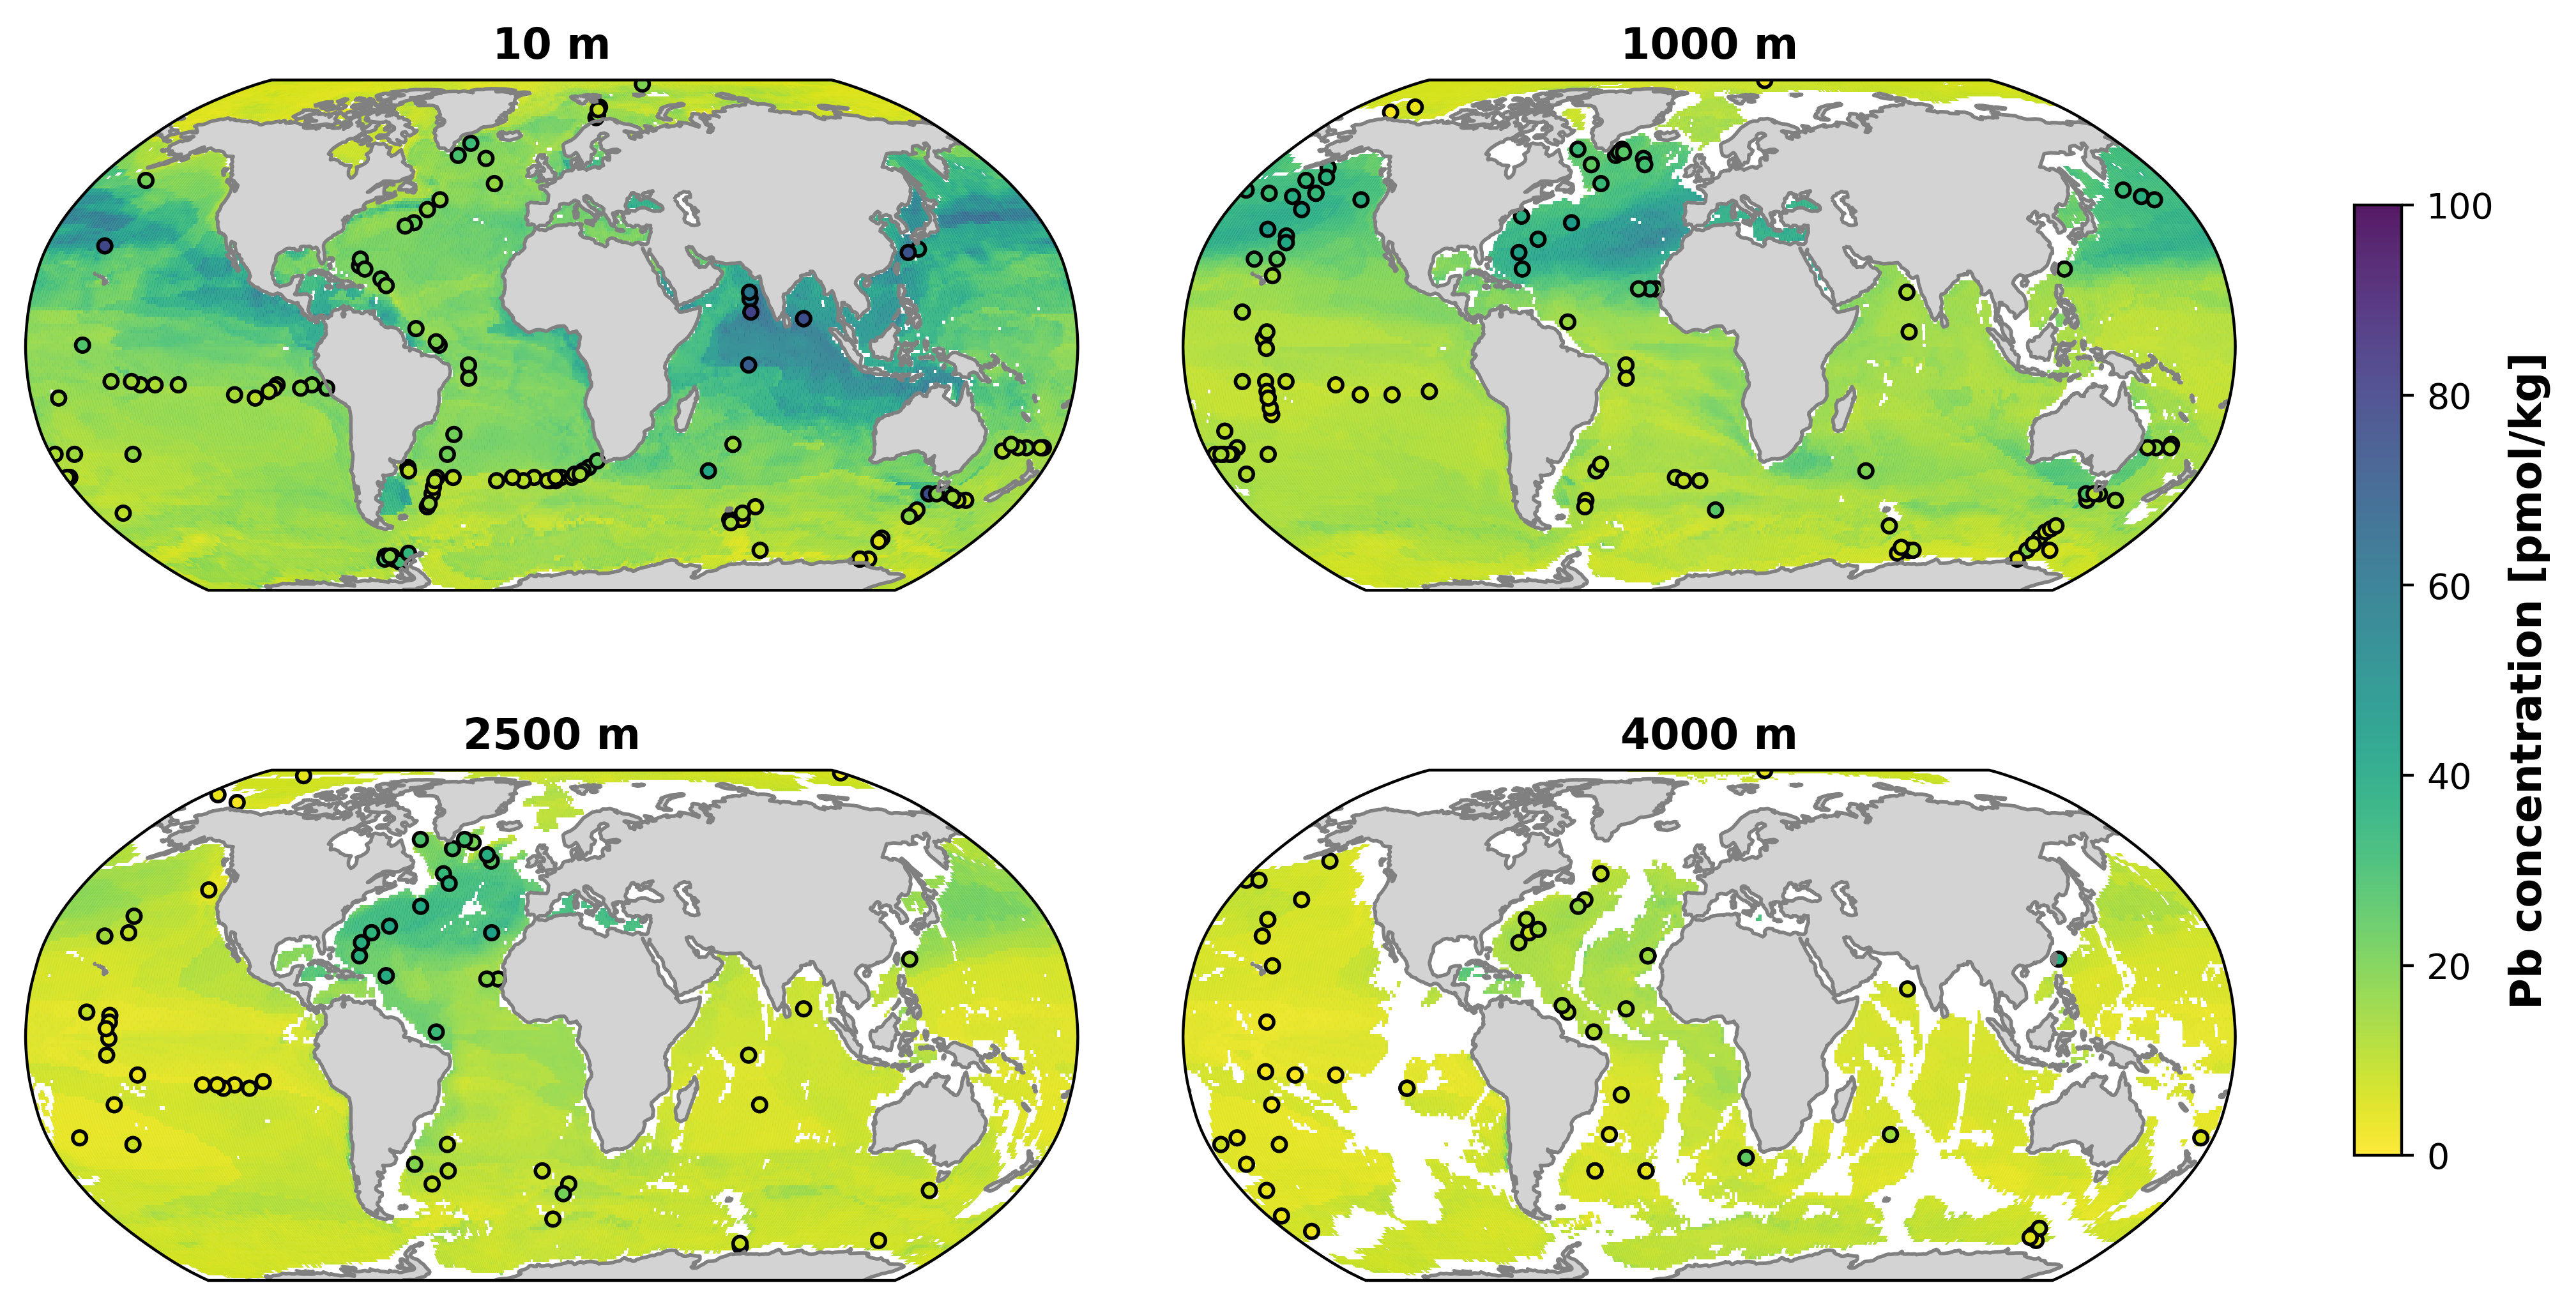

In [228]:
fig, axes = plt.subplots(2,2, figsize=(12,7), dpi = 400, subplot_kw=dict(projection=ccrs.Robinson()), gridspec_kw = {'wspace':0.1, 'hspace':0.005})

for i, ax in enumerate(fig.axes):
    cs = ax.pcolormesh(lon, lat, dfs[i], cmap = 'viridis_r', vmin =0, vmax = 100, transform=ccrs.PlateCarree(),alpha=0.9)
    ax.add_feature(cfeature.LAND, color='lightgrey')
    ax.add_feature(cfeature.COASTLINE, color = 'grey')
    ax.scatter(merged_df[merged_df['WOD_depth_x'].isin(ranges[i])]['WOD_longitude [degrees_east]'], merged_df[merged_df['WOD_depth_x'].isin(ranges[i])]['WOD_latitude [degrees_north]'], c = merged_df[merged_df['WOD_depth_x'].isin(ranges[i])]['y_test'], cmap = 'viridis_r', vmin =0, vmax = 100, edgecolors='black', s = 15, transform=ccrs.PlateCarree())
    ax.set_title(titles[i], fontweight='bold')
    
fig.colorbar(cs, ax=axes.ravel().tolist(), orientation = 'vertical', fraction = 0.02, pad = 0.05).set_label(label='Pb concentration [pmol/kg]', fontweight='bold', fontsize=12)

plt.savefig('../../Figures/For_ms/Pb_conc-cleanedSO_maps-no-coords_pcolormesh.jpg')

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


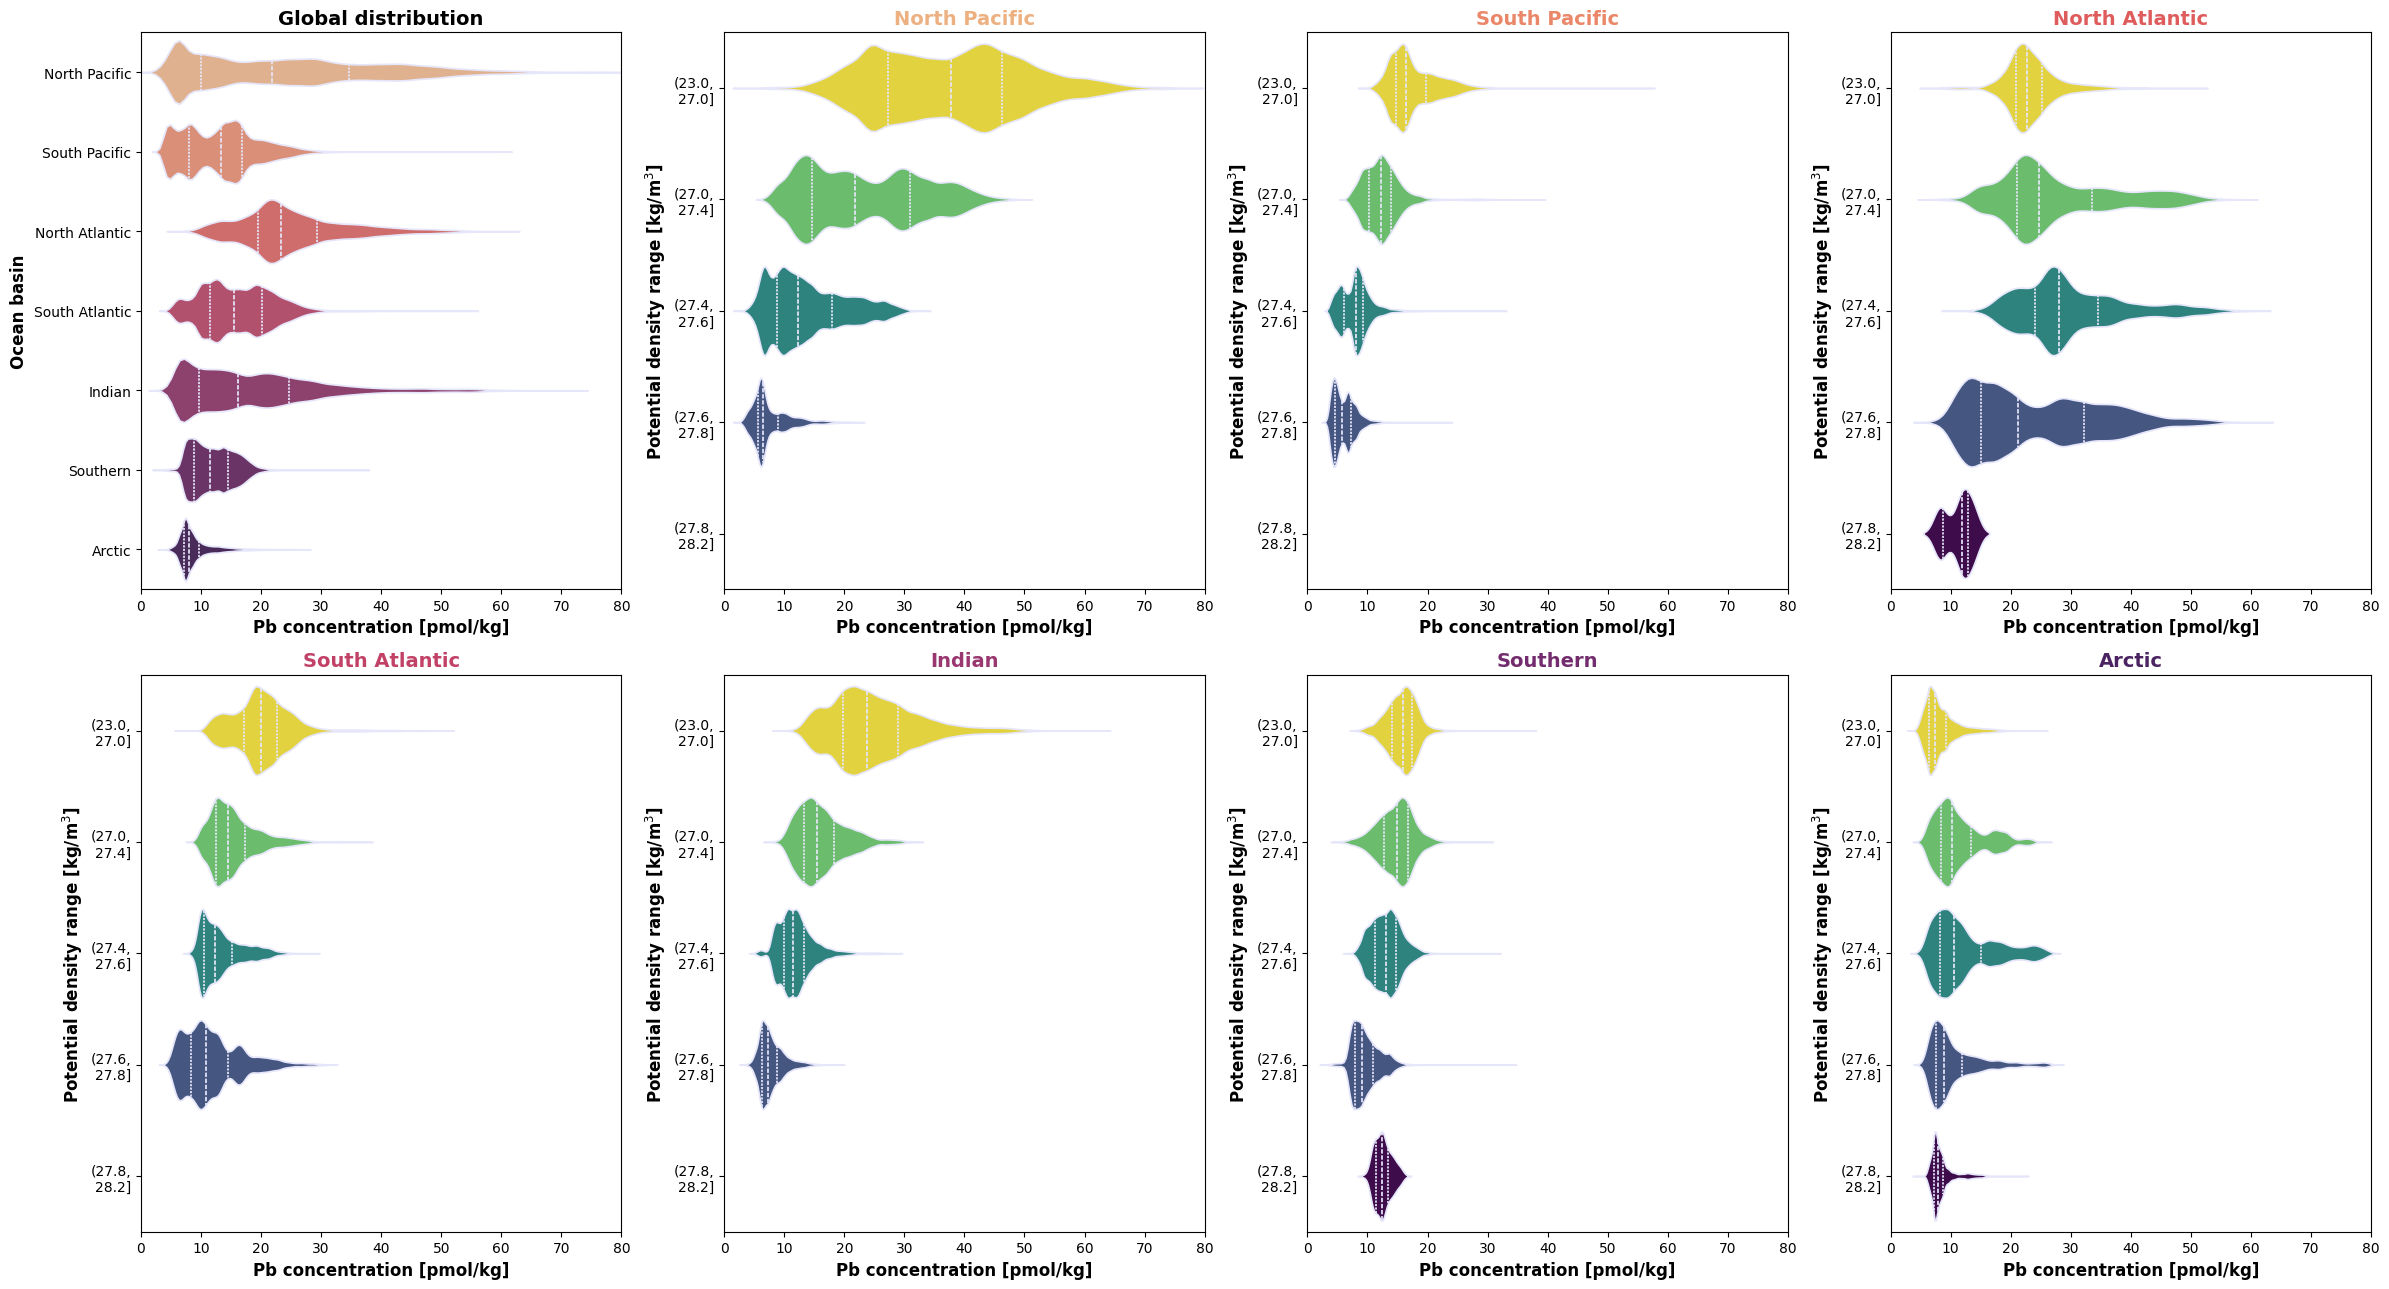

In [188]:
prediction_df_latlon_NS = prediction_df_latlon.copy()

for basin in ['Pacific', 'Atlantic']:
    prediction_df_latlon_NS.loc[(prediction_df_latlon_NS['Ocean_basin'] == basin) & (prediction_df_latlon_NS['WOD_latitude [degrees_north]'] >= 0), 'Ocean_basin'] = f'North {basin}'
    prediction_df_latlon_NS.loc[(prediction_df_latlon_NS['Ocean_basin'] == basin) & (prediction_df_latlon_NS['WOD_latitude [degrees_north]'] < 0), 'Ocean_basin'] = f'South {basin}'

basins = ['North Pacific', 'South Pacific', 'North Atlantic', 'South Atlantic', 'Indian', 'Southern', 'Arctic']
potential_densities = [23, 27, 27.4, 27.6, 27.8, 28.2]
colors = []
basin_colors = []

fig, axes = plt.subplots(2, int((len(basins)+1)/2), figsize=(24,13))

for i in np.linspace(0, 255, len(basins)).astype(int):
    basin_colors.append(sns.color_palette('flare', 256)[i])

for i in np.linspace(0, 255, len(potential_densities)-1).astype(int):
    colors.append(sns.color_palette('viridis_r', 256)[i])

for j, ax in enumerate(axes.flat):
    if j == 0:
        sns.violinplot(x='Pb_conc', hue='Ocean_basin', y='Ocean_basin', data=prediction_df_latlon_NS[prediction_df_latlon_NS['Ocean_basin'].isin(basins)], ax=ax, palette=basin_colors, order=basins, hue_order=basins, linecolor='lavender', inner='quart', legend=False)        
        ax.set_xlim(0, 80)
        ax.set_title('Global distribution', fontweight='bold', fontsize = 14)
        ax.set_ylabel('Ocean basin', fontweight='bold', fontsize = 12)
        ax.set_xlabel('Pb concentration [pmol/kg]', fontweight='bold', fontsize = 12)

    else:
        basin_df = prediction_df_latlon_NS[prediction_df_latlon_NS['Ocean_basin'] == basins[j-1]]
        sns.violinplot(x='Pb_conc', y=pd.cut(prediction_df_latlon_NS.potential_density, potential_densities), hue=pd.cut(prediction_df_latlon_NS.potential_density, potential_densities), data=basin_df, ax=ax, linecolor='lavender', palette=colors, inner='quart', legend=False)
        ax.set_title(basins[j-1], fontweight='bold', fontsize = 14, color = basin_colors[j-1])
        ax.set_xlim(0, 80)
        ax.set_ylabel('Potential density range [kg/m$^{3}$]', fontweight='bold', fontsize = 12)
        ax.set_xlabel('Pb concentration [pmol/kg]', fontweight='bold', fontsize = 12)
        ax.set_yticklabels(['(23.0,\n27.0]', '(27.0,\n27.4]', '(27.4,\n27.6]', '(27.6,\n27.8]', '(27.8,\n28.2]'])

plt.tight_layout(w_pad=1)

plt.savefig('../../Figures/For_ms/Pb-conc_violin-predictions_no-coords-NS-density.jpg', dpi = 400)

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


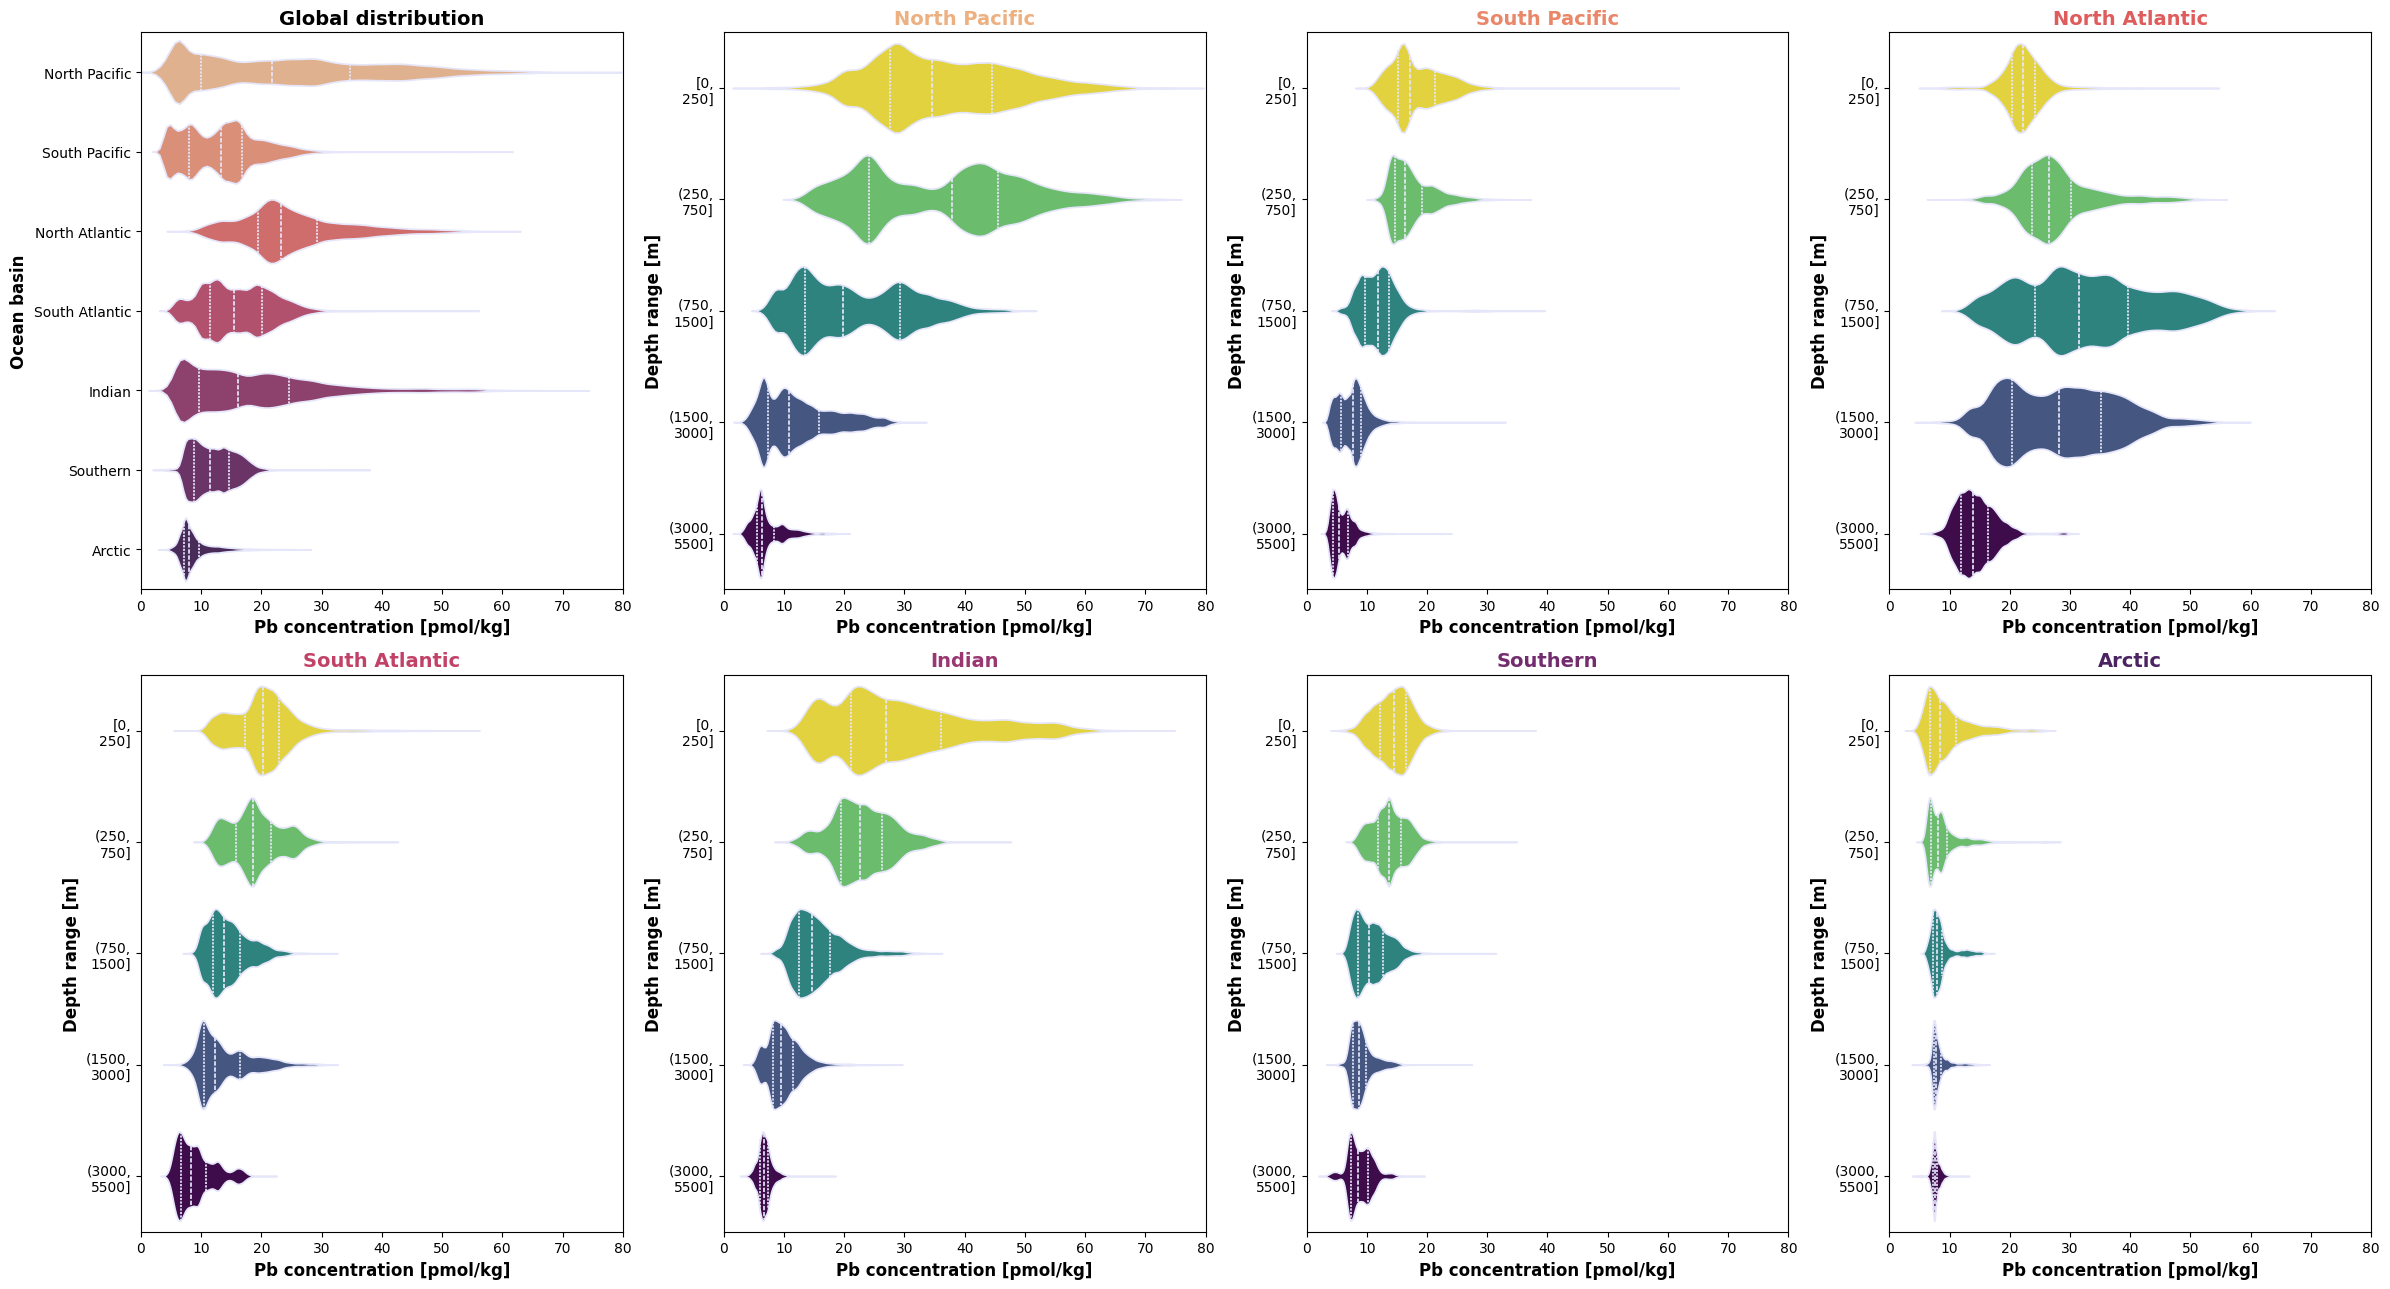

In [189]:
prediction_df_latlon_NS = prediction_df_latlon.copy()

for basin in ['Pacific', 'Atlantic']:
    prediction_df_latlon_NS.loc[(prediction_df_latlon_NS['Ocean_basin'] == basin) & (prediction_df_latlon_NS['WOD_latitude [degrees_north]'] >= 0), 'Ocean_basin'] = f'North {basin}'
    prediction_df_latlon_NS.loc[(prediction_df_latlon_NS['Ocean_basin'] == basin) & (prediction_df_latlon_NS['WOD_latitude [degrees_north]'] < 0), 'Ocean_basin'] = f'South {basin}'

basins = ['North Pacific', 'South Pacific', 'North Atlantic', 'South Atlantic', 'Indian', 'Southern', 'Arctic']
depths = [0, 250, 750, 1500, 3000, 5500]
colors = []
basin_colors = []

fig, axes = plt.subplots(2, int((len(basins)+1)/2), figsize=(24,13))

for i in np.linspace(0, 255, len(basins)).astype(int):
    basin_colors.append(sns.color_palette('flare', 256)[i])

for i in np.linspace(0, 255, len(depths)-1).astype(int):
    colors.append(sns.color_palette('viridis_r', 256)[i])

for j, ax in enumerate(axes.flat):
    if j == 0:
        sns.violinplot(x='Pb_conc', hue='Ocean_basin', y='Ocean_basin', data=prediction_df_latlon_NS[prediction_df_latlon_NS['Ocean_basin'].isin(basins)], ax=ax, palette=basin_colors, order=basins, hue_order=basins, linecolor='lavender', inner='quart', legend=False)        
        ax.set_xlim(0, 80)
        ax.set_title('Global distribution', fontweight='bold', fontsize = 14)
        ax.set_ylabel('Ocean basin', fontweight='bold', fontsize = 12)
        ax.set_xlabel('Pb concentration [pmol/kg]', fontweight='bold', fontsize = 12)

    else:
        basin_df = prediction_df_latlon_NS[prediction_df_latlon_NS['Ocean_basin'] == basins[j-1]]
        sns.violinplot(x='Pb_conc', y=pd.cut(prediction_df_latlon_NS.Depth, depths), hue=pd.cut(prediction_df_latlon_NS.Depth, depths), data=basin_df, ax=ax, linecolor='lavender', palette=colors, inner='quart', legend=False)
        ax.set_title(basins[j-1], fontweight='bold', fontsize = 14, color = basin_colors[j-1])
        ax.set_xlim(0, 80)
        ax.set_ylabel('Depth range [m]', fontweight='bold', fontsize = 12)
        ax.set_xlabel('Pb concentration [pmol/kg]', fontweight='bold', fontsize = 12)
        ax.set_yticklabels(['[0,\n250]', '(250,\n750]', '(750,\n1500]', '(1500,\n3000]', '(3000,\n5500]'])

plt.tight_layout(w_pad=1)

plt.savefig('../../Figures/For_ms/Pb-conc_violin-predictions_no-coords-NS-depth.jpg', dpi = 400)

### Other figures

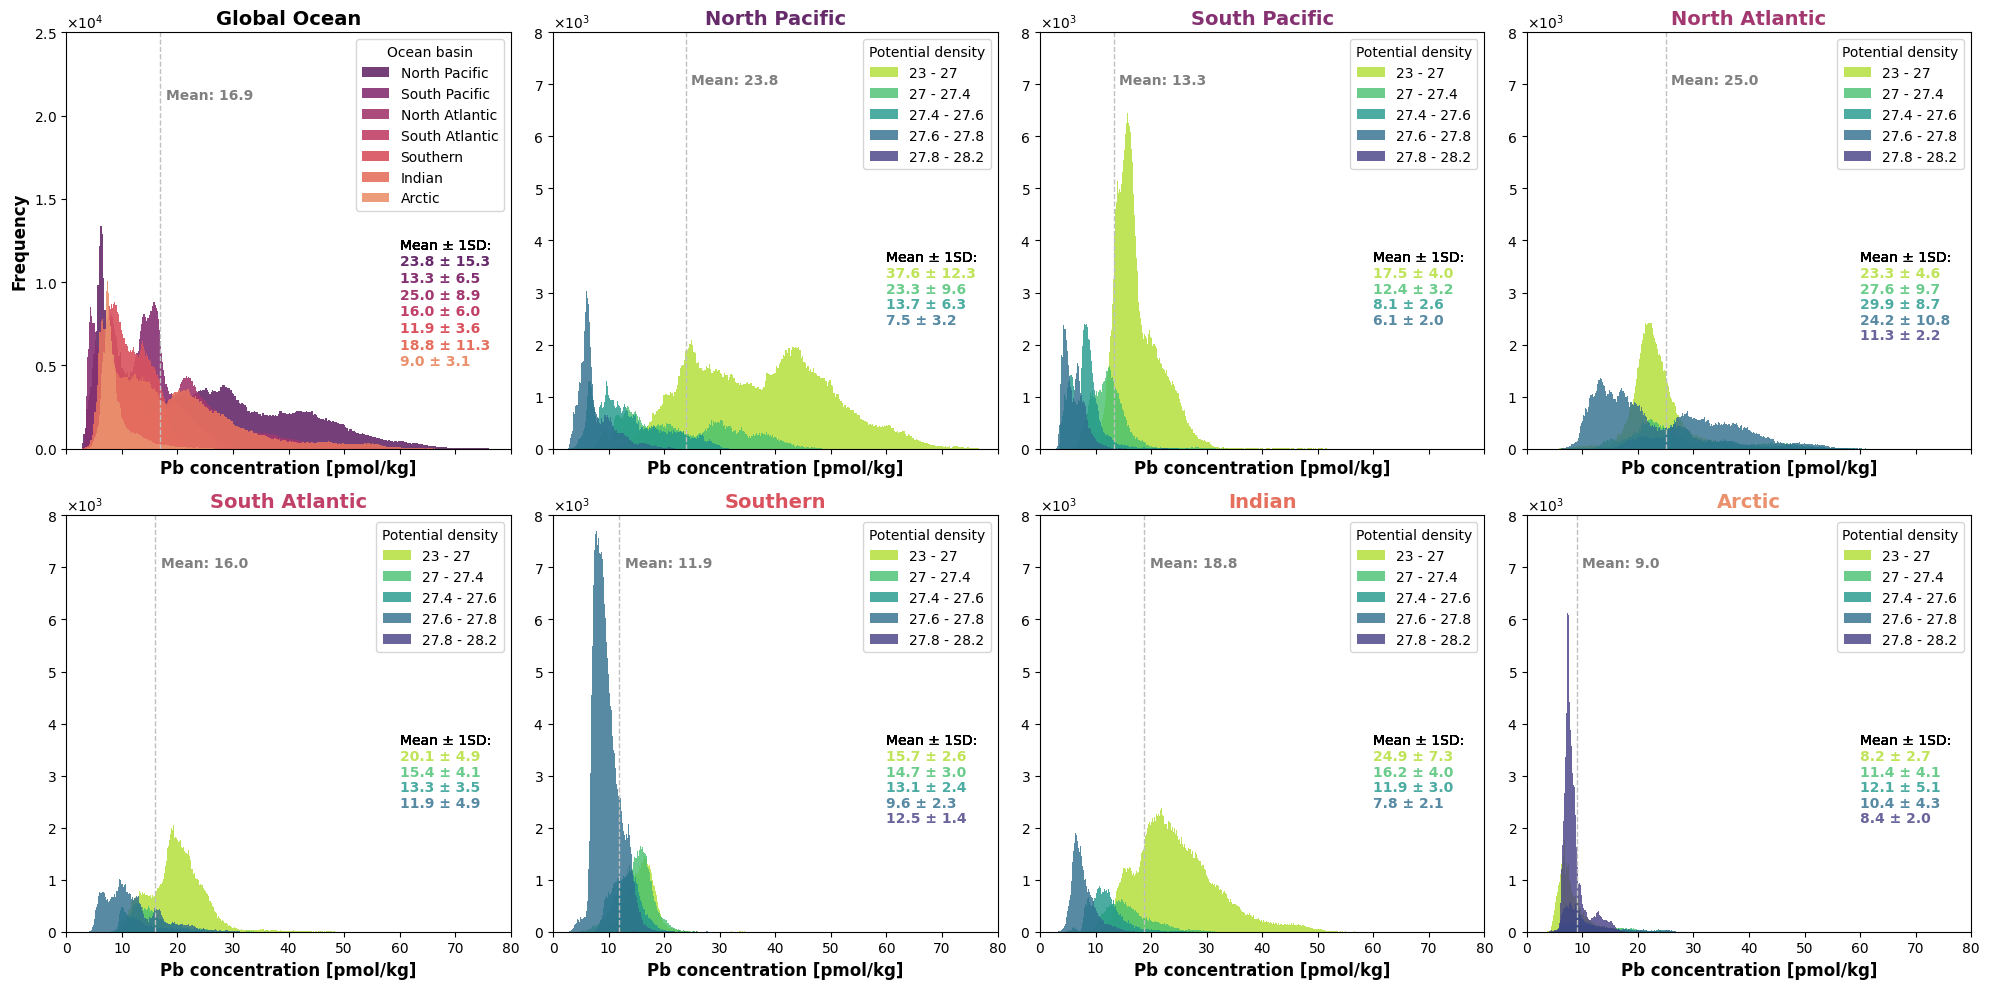

In [145]:
prediction_df_latlon_NS = prediction_df_latlon.copy()

for basin in ['Pacific', 'Atlantic']:
    prediction_df_latlon_NS.loc[(prediction_df_latlon_NS['Ocean_basin'] == basin) & (prediction_df_latlon_NS['WOD_latitude [degrees_north]'] >= 0), 'Ocean_basin'] = f'North {basin}'
    prediction_df_latlon_NS.loc[(prediction_df_latlon_NS['Ocean_basin'] == basin) & (prediction_df_latlon_NS['WOD_latitude [degrees_north]'] < 0), 'Ocean_basin'] = f'South {basin}'

basins = ['North Pacific', 'South Pacific', 'North Atlantic', 'South Atlantic', 'Southern', 'Indian', 'Arctic']
potential_densities = [23, 27, 27.4, 27.6, 27.8, 28.2]
colors = []
basin_colors = []

fig, axes = plt.subplots(2, int((len(basins)+1)/2), sharex=True, figsize=(20,10))

for i in np.linspace(30, 255, len(basins)+1).astype(int):
    basin_colors.append(sns.color_palette('flare_r', 256)[i])

for i in np.linspace(30, 255, len(potential_densities)).astype(int):
    colors.append(sns.color_palette('viridis_r', 256)[i])

for j, ax in enumerate(axes.flat):
    if j == 0:
        for i in np.arange(0, len(basins)):
            basin_df = prediction_df_latlon_NS[prediction_df_latlon_NS['Ocean_basin'] == basins[i]]
            ax.hist(basin_df['Pb_conc'], bins=300, alpha=0.9, color = basin_colors[i], label=basins[i])
            ax.set_ylabel('Frequency', fontweight='bold', fontsize = 12)
            ax.set_title('Global Ocean', fontweight='bold', fontsize = 14)
            ax.text(60, 12000, f'Mean ± 1SD:', color='black', fontsize=10)
            ax.text(60, (len(basins)-i)*1000+4000, f'{round(basin_df["Pb_conc"].mean(), 1):.1f} ± {round(basin_df["Pb_conc"].std(), 1):.1f}', color=basin_colors[i], fontsize=10, fontweight='bold')
            ax.set_ylim(0, 25000)               
        ax.vlines(prediction_df_latlon_NS['Pb_conc'].mean(), ymin=0, ymax=26000, color='silver', linestyle='dashed', linewidth=1)
        ax.text(prediction_df_latlon_NS['Pb_conc'].mean()+1, 21000, f'Mean: {round(prediction_df_latlon_NS["Pb_conc"].mean(), 1):.1f}', color='gray', fontsize=10, fontweight='bold')
        ax.legend(fontsize=10, loc='upper right', title='Ocean basin')

    else:
        for i in np.arange(0, len(potential_densities)-1):
            density_df = prediction_df_latlon_NS[(prediction_df_latlon_NS['potential_density'] >= potential_densities[i]) & (prediction_df_latlon_NS['potential_density'] < potential_densities[i+1]) & (prediction_df_latlon_NS['Ocean_basin'] == basins[j-1])]
            ax.hist(density_df['Pb_conc'], bins=300, alpha=0.8, color = colors[i], label=f'{potential_densities[i]} - {potential_densities[i+1]}')
            ax.set_title(basins[j-1], fontweight='bold', fontsize = 14, color = basin_colors[j-1])
            ax.text(60, 3600, f'Mean ± 1SD:', color='black', fontsize=10, zorder=1)
            if f'{round(density_df["Pb_conc"].mean(), 3):.3f}' != 'nan':
                ax.text(60, (len(basins)-i)*300+1200, f'{round(density_df["Pb_conc"].mean(),1):.1f} ± {round(density_df["Pb_conc"].std(), 1):.1f}', color=colors[i], fontsize=10, fontweight='bold', alpha = 0.8, zorder=1)
            ax.set_ylim(0, 8000)
        #rect = Rectangle((59, 1700), 19, 1600, edgecolor='black', facecolor='black', zorder=0)    
        #ax.add_patch(rect)
        ax.vlines(prediction_df_latlon_NS[prediction_df_latlon_NS['Ocean_basin']==basins[j-1]]['Pb_conc'].mean(), ymin=0, ymax=26000, color='silver', linestyle='dashed', linewidth=1)
        ax.text(prediction_df_latlon_NS[prediction_df_latlon_NS['Ocean_basin']==basins[j-1]]['Pb_conc'].mean()+1, 7000, f'Mean: {round(prediction_df_latlon_NS[prediction_df_latlon_NS["Ocean_basin"]==basins[j-1]]["Pb_conc"].mean(), 1):.1f}', color='gray', fontsize=10, fontweight='bold')
        ax.legend(fontsize=10, loc='upper right', title= 'Potential density')
    
    ax.set_xlabel('Pb concentration [pmol/kg]', fontweight='bold', fontsize = 12)
    ax.set_xlim(0,80)
    ax.ticklabel_format(axis='y', scilimits=(0,0), style='sci', useMathText=True)

plt.tight_layout(w_pad=1)

plt.savefig('../../Figures/Pb_conc_hist-predictions_no-coords-density_v2.jpg', dpi = 400)